## 3. Linear Regression

Using CPI as an indicator of an inflationary environment, we used linear regression analysis to evaluate the suitability of each factor in predicting the likelihood of inflation. As our datasets all contain time-series data, we believe that it is appropriate to begin with linear regression to evaluate the factors we have identified.

In [3]:
# Import essential libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sb
from datetime import datetime

# Import linear regression libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [5]:
# This function cleans a dataframe to change datetime to %Y-%m format
def df_dates_monthly(df, Date = 'Date'):
    clean_df = df.copy()
    clean_df[Date] = pd.to_datetime(clean_df[Date])
    clean_df[Date] = clean_df[Date].dt.strftime('%Y-%m')
    return clean_df

### Predicting CPI using US Unemployment Rate

In [22]:
cpi_data = pd.read_csv("data/cpi_monthly.csv")
cpi_data.rename(columns={'DATE': 'Date'}, inplace=True)
cpi_data.rename(columns={'CPIAUCSL': 'Value'}, inplace=True)
cpi_data_clean = df_dates_monthly(cpi_data)

In [24]:
# Clean CPI data to have same time period as Unemployment Rate data
cpi_data_clean = cpi_data_clean[(cpi_data_clean.Date>='1948-01') & (cpi_data_clean.Date<='2021-11')]

In [26]:
cpi_data_clean.shape

(887, 2)

In [28]:
unemp_data = pd.read_csv("data/unemployment_rate_data.csv")

# Clean unemployment data to have date in %Y-%m format
unemp_data.rename({"date": "Date","unrate": "Rate"},axis=1,inplace=True)
unemp_data = df_dates_monthly(unemp_data)

# Clean unemployment data to keep columns Date and unemployment rate
unemp_data_clean = pd.DataFrame(unemp_data[['Date','Rate']])

In [30]:
unemp_data_clean.shape

(887, 2)

In [32]:
# Create new dateframes for reference
unemp = pd.DataFrame(unemp_data_clean[['Rate']])
cpi = pd.DataFrame(cpi_data_clean[['Value']])

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


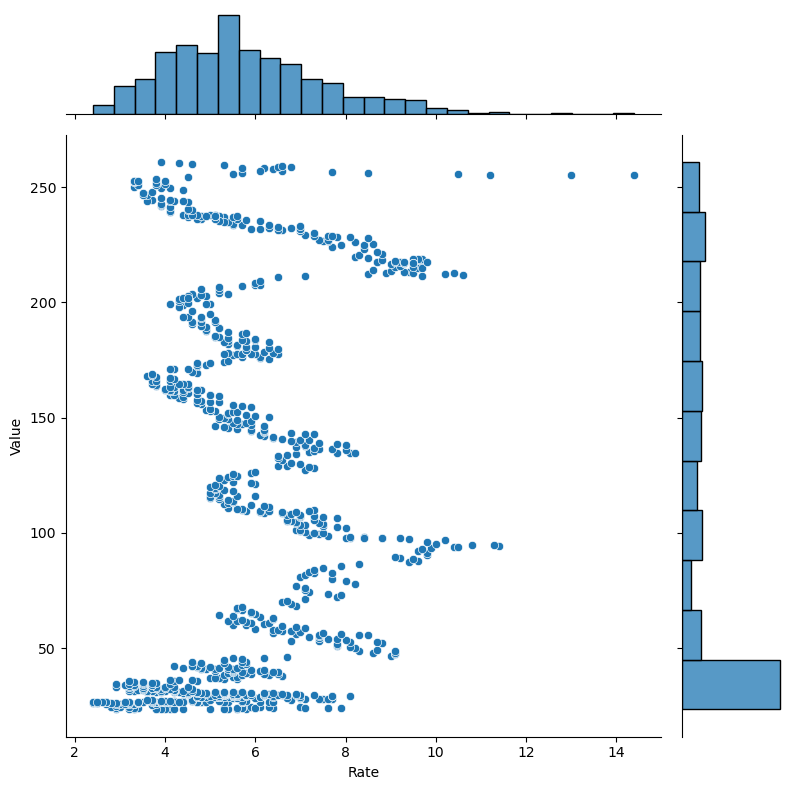

In [34]:
# Visualise relationship between CPI and Unemployment rate data
cpi_unemp_data = pd.concat([unemp,cpi], axis=1).reindex(unemp.index)
sb.jointplot(data=cpi_unemp_data, x='Rate', y='Value', height = 8)

#### Preparing train and test datasets
> Total data points: 887 values  
> Train set: 710 values (80% of total size)  
> Test set: 177 values (20% of total size)

In [37]:
# Preparation of train and test datasets
unemp_train, unemp_test, cpi_train, cpi_test = train_test_split(unemp,cpi,test_size=177)

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer

# Define a pipeline for polynomial feature expansion and regression
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),  # Adds polynomial and interaction terms
    ('regressor', LinearRegression())  # Placeholder for the regressor
])

# Define hyperparameter grid
param_grid = [
    {
        'poly__degree': [1, 2, 3],  # Polynomial degrees to consider
        'regressor': [LinearRegression()],
        'regressor__fit_intercept': [True, False]  # Specific to LinearRegression
    },
    {
        'poly__degree': [1, 2, 3],
        'regressor': [Ridge()],
        'regressor__alpha': [0.1, 1.0, 10.0]  # Specific to Ridge
    },
    {
        'poly__degree': [1, 2, 3],
        'regressor': [Lasso()],
        'regressor__alpha': [0.1, 1.0, 10.0]  # Specific to Lasso
    }
]

# Custom scoring function (e.g., mean squared error)
scoring = make_scorer(mean_squared_error, greater_is_better=False)

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring)

# Fit to the training data
grid_search.fit(unemp_train, cpi_train)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
print("Best Model:", grid_search.best_estimator_)

# Predict on test data using the best model
cpi_pred = grid_search.predict(unemp_test)
mse = mean_squared_error(cpi_test, cpi_pred)
print("Test Set MSE:", mse)

Best Parameters: {'poly__degree': 3, 'regressor': Lasso(alpha=0.1), 'regressor__alpha': 0.1}
Best Model: Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('regressor', Lasso(alpha=0.1))])
Test Set MSE: 6983.044190259819


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.403e+06, tolerance: 3.598e+02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.342e+06, tolerance: 3.643e+02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.390e+06, toler

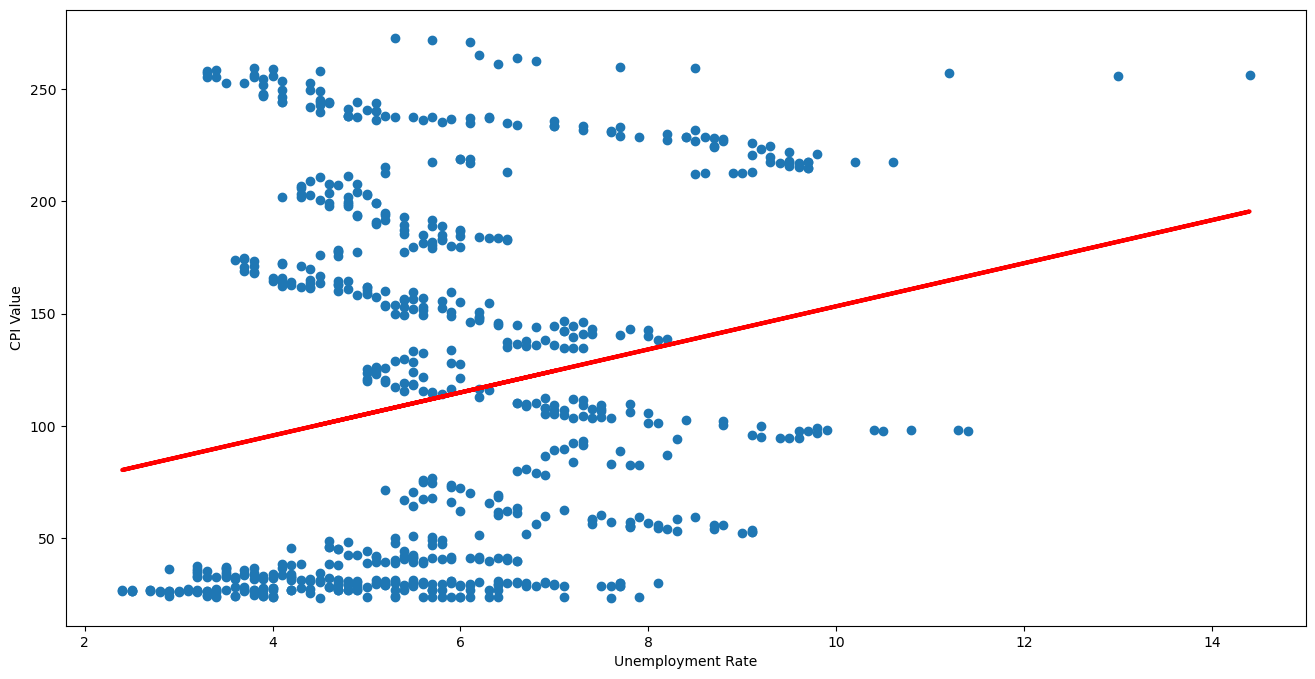

In [54]:
# Plot regression line
regline_x = unemp_train
regline_y = linreg_unemp.intercept_ + linreg_unemp.coef_*unemp_train

# Plot scatter plot with regression line 
f, axes = plt.subplots(1,1,figsize=(16,8))
plt.scatter(unemp_train, cpi_train)
plt.plot(regline_x, regline_y, 'r-', linewidth=3)
plt.xlabel("Unemployment Rate")
plt.ylabel("CPI Value")
plt.show()

In [56]:
# Explained variance for comparison 
ev_unemp = round(linreg_unemp.score(unemp_train,cpi_train),2)

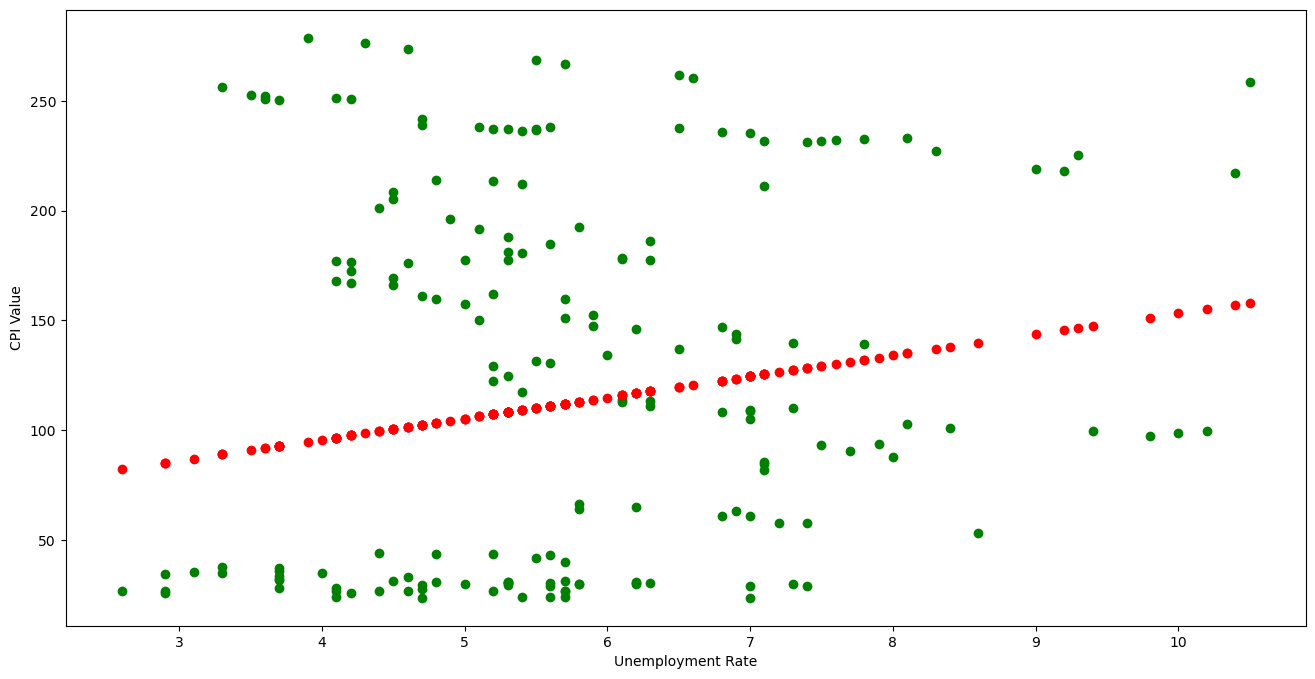

In [58]:
# Use linear regression model on test set
cpi_test_pred = linreg_unemp.predict(unemp_test)

f,axes = plt.subplots(1,1,figsize=(16,8))
plt.scatter(unemp_test, cpi_test, color='green')
plt.scatter(unemp_test, cpi_test_pred, color='red')
plt.xlabel("Unemployment Rate")
plt.ylabel("CPI Value")
plt.show()

In [60]:
# Root Mean Squared Error (RMSE) for comparison
rmse_unemp = round(mean_squared_error(cpi_test, cpi_test_pred, squared=False),2)

### Predicting CPI using S&P 500 data